In [0]:
import pandas as pd

FILE = "committee_utterances.tsv"
path = "drive/My Drive/Colab Notebooks/466-proj2/"

df = pd.read_csv(path + FILE, sep='\t')

In [3]:
#Select a random 25% (1/4) of the content
import random
from pprint import pprint

records = list(df.text)
number_selected = len(records) // 16  #TODO CHANGE THIS VALUE TO 4
selected_records = random.sample(records, number_selected) #get random sample of number_selected records without replacement

utterances = [record for record in selected_records] #get all the utterance fields only (column #15) for clustering
print("total number of points:",len(utterances))

total number of points: 1928


In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.corpus import wordnet 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
punctuation = "-!?;:\"\'.,"

def getPOS(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def getFeatures(text):
    features = {}
    tokens = nltk.word_tokenize(text.lower())
    tot_cnt = len(tokens)
    for word in tokens:        
        if word.isnumeric():
            label = '[NUMBER]'
            if label not in features:
                features[label] = 1/float(tot_cnt)    
            else:
                features[label] += 1/float(tot_cnt)    
        elif word not in stop_words and word not in punctuation:
            w = wordnet_lemmatizer.lemmatize(word, getPOS(word))
            if w not in features:
                features[w] = 1/float(tot_cnt)
            else:
                features[w] += 1/float(tot_cnt)
    return features


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
import numpy as np
import random, sys, copy
from collections import Counter

max_t = -1   # max itterations (ignores threshold) (-1 to unset)10

def initCentroids(vec_data, k):
    centroidID = np.random.permutation(len(vec_data))[:k]
    print(centroidID)
    return [vec_data[cID] for cID in centroidID]

def calculateDistance(v_dict, u_dict):
    v = list(v_dict.values())
    u = list(u_dict.values())
    total = 0
    for i in range(0, len(v)):
        total += ((v[i] - u[i]) ** 2)
    return np.sqrt(total)


# takes a vector dictionary and a set of all the keys
# returns a new vector dictionary with all the keys
def reshapeVectDict(vect_dict, keys):
    result = copy.deepcopy(vect_dict)
    for key in keys:
        if key not in result:
            result[key] = 0.0
    return result

# For a given point, find the closest centroid from the list, return centroid's index
def closestCentroid(point, k, data):
    # Get all the keys (words) in the point and centroids
    # This will be used to transform them to the same dimension so we can do math
    all_keys = []
    all_keys.extend(point)        
    for cID in range(0,k):        
        all_keys.extend(data[cID].keys())
    all_keys = set(all_keys)

    closestCentroid = 0
    minDist = sys.maxsize
    point_reshape = reshapeVectDict(point, all_keys)

    # print()
    # print("point: ", point_reshape)
    for cID in range(0,k):
        centroid = data[cID]
        centroid_reshape = reshapeVectDict(centroid, all_keys)
        dist = calculateDistance(point_reshape, centroid_reshape)

        # print("dist: ", dist, "centroid: ", centroid)
        if (dist < minDist):
            minDist = dist          
            closestCentroid = cID

    # print("closestCentroid: ", closestCentroid, "minDist: ", minDist)
    return closestCentroid

def recalculateCentroid(cluster, data):
    new_centroid = {}
    for idx in cluster:
        point = data[idx]
        new_centroid = dict(Counter(new_centroid) + Counter(point))

    for key in new_centroid:
        new_centroid[key] /= len(cluster)
    # print("new_centroid: ", new_centroid)
    return new_centroid

def calculateConvergence(k, t, M):
    difference = 0
    for i in range(0, k):
        v = list(M[t][i].values())
        u = list(M[t-1][i].values())
        diff = (np.mean(u) - np.mean(v)) ** 2
        difference += diff
        print("diff: ", diff)
    print("difference: ", difference)
    return difference

def k_means(vec_data, k, e):
    M = []
    M.append([0 for i in range(0, k)])

    t = 0
    M[t] = initCentroids(vec_data, k)

    # if max_t >= 0:        
    #     while (t < max_t):
    #         print("iteration: ", t)
    #         t += 1
    #         M.append([0 for i in range(0, k)])    # M needs t rows
    #         C = []
    #         for i in range(0, k):
    #             C.append([])
    #         # Centroid assignment
    #         for point in vec_data:
    #             clusterID = closestCentroid(point, k, M[t-1])                
    #             C[clusterID].append(vec_data.index(point))    # keep track of the point's as indices
    #         print(len(C), C)
            
    #         # Centroid update
    #         for i in range(0, k):
    #             new_centroid = recalculateCentroid(C[i], vec_data)
    #             M[t][i] = new_centroid
    # else:
    while(calculateConvergence(k, t, M) < e):
        print("iteration: ", t)
        t += 1
        M.append([0 for i in range(0, k)])    # M needs t rows
        C = []
        for i in range(0, k):
            C.append([])
        # Centroid assignment
        for point in vec_data:
            clusterID = closestCentroid(point, k, M[t-1])                
            C[clusterID].append(vec_data.index(point))    # keep track of the point's as indices
        print(len(C), C)
        
        # Centroid update
        for i in range(0, k):
            new_centroid = recalculateCentroid(C[i], vec_data)
            M[t][i] = new_centroid 
    
    return C

In [6]:
data = selected_records
vec_data = [getFeatures(text) for text in data]
print(len(vec_data))
# vec_data

1928


In [0]:
vec_data[:10]

In [7]:
import time

startTime = time.time()
endTime = time.time()

clusters = k_means(vec_data, 5, 1)

print(round(endTime - startTime,3),'seconds')

[1505 1886 1855 1663  899]
diff:  0.0
diff:  0.0
diff:  0.0
diff:  0.0
diff:  0.0
difference:  0.0
iteration:  0
5 [[2, 8, 23, 30, 37, 51, 52, 57, 74, 77, 78, 91, 108, 118, 121, 123, 133, 135, 146, 163, 167, 181, 182, 183, 188, 196, 211, 214, 217, 221, 238, 263, 283, 285, 286, 292, 303, 304, 307, 313, 317, 327, 333, 337, 342, 343, 347, 360, 366, 368, 369, 378, 388, 394, 410, 414, 415, 425, 428, 436, 440, 441, 442, 458, 460, 462, 465, 468, 472, 476, 481, 482, 501, 525, 531, 532, 533, 540, 547, 567, 568, 571, 572, 580, 585, 599, 616, 617, 633, 636, 641, 642, 648, 653, 673, 674, 679, 687, 689, 700, 701, 718, 719, 728, 731, 736, 737, 739, 740, 759, 770, 781, 342, 787, 799, 800, 801, 817, 183, 825, 828, 829, 850, 852, 861, 863, 878, 885, 886, 888, 890, 903, 906, 909, 910, 917, 925, 934, 939, 943, 949, 955, 963, 964, 965, 981, 991, 996, 1005, 1006, 1014, 1024, 1033, 1056, 1066, 1067, 1069, 1073, 1076, 1078, 1084, 1090, 1091, 1108, 1111, 1113, 1120, 1129, 1140, 1150, 1166, 1175, 1176, 1180, 1

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
for IDX in range(0, len(clusters)):
    print("Cluster ", IDX, " contains:")
    samples = [vec_data[i] for i in clusters[IDX]]
    print(samples)

Cluster  0  contains:
[{'due': 0.07692307692307693, 'pas': 0.07692307692307693, 'amend': 0.07692307692307693, 'appropriation': 0.07692307692307693, 'current': 0.07692307692307693, 'vote': 0.07692307692307693, '[NUMBER]': 0.07692307692307693, '0.': 0.07692307692307693, 'fuller': 0.07692307692307693}, {'federal': 0.08333333333333333, 'emergency': 0.08333333333333333, 'shelter': 0.08333333333333333, 'grant': 0.08333333333333333, 'program': 0.08333333333333333, 'homelessness': 0.08333333333333333, 'assistance': 0.08333333333333333}, {'establish': 0.08333333333333333, 'quorum': 0.08333333333333333, 'yet': 0.041666666666666664, 'upon': 0.041666666666666664, 'interrupt': 0.041666666666666664}, {'sorry': 0.07692307692307693, 'want': 0.07692307692307693, 'add': 0.07692307692307693, 'kelly': 0.07692307692307693, 'hardy': 0.07692307692307693, 'child': 0.07692307692307693, 'support': 0.07692307692307693}, {'good': 0.16666666666666666, 'answer': 0.16666666666666666, 'thank': 0.16666666666666666}, {

In [0]:
plt.scatter()

In [0]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize


### Vectorize features
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train_vec = vectorizer.fit_transform(map(getFeatures, data))

# tf_idf_vectorizor = TfidfVectorizer(analyzer=getFeatures,
#                              max_features = 20000)
# tf_idf = tf_idf_vectorizor.fit_transform(data)
# tf_idf_norm = normalize(tf_idf)
# tf_idf_array = tf_idf_norm.toarray()

In [218]:
X_train_vec.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03571429, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02564103, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [0]:
from sklearn.cluster import KMeans
from sklearn import decomposition

# sklearn_pca = decomposition.PCA(n_components = 2)

# Y_sklearn = sklearn_pca.fit_transform(X_train_vec)
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X_train_vec)


In [0]:
# TEST
inverse = vectorizer.inverse_transform(X_train_vec)
inverse

In [0]:
# Takes a list of vect-dicts that describe the cluster, and converts the data to a list of their cluster labels
def getClusterLabel(item, clusters):
    for cluster in clusters:
        if item in cluster:
            return clusters.index(cluster)

def summarizeClusters(clusters):
    summary = []
    for cluster in clusters:
        summary.append(len(cluster))
    return [cid for cid in range(0, len(clusters))], summary

In [54]:
summarizeClusters(clusters)

([0, 1, 2, 3, 4], [604, 11, 0, 1313, 0])

In [45]:
length = 0
for cluster in clusters:
    length += len(cluster)
print(length)

1928


In [35]:
record = vec_data[0]
print(record)
t_label = getClusterLabel(0, clusters)
print(t_label)

{'due': 0.07692307692307693, 'pas': 0.07692307692307693, 'amend': 0.07692307692307693, 'appropriation': 0.07692307692307693, 'current': 0.07692307692307693, 'vote': 0.07692307692307693, '[NUMBER]': 0.07692307692307693, '0.': 0.07692307692307693, 'fuller': 0.07692307692307693}
[0, 4, 9, 12, 15, 20, 22, 24, 25, 27, 28, 29, 33, 34, 35, 38, 41, 28, 44, 46, 50, 28, 62, 63, 64, 28, 74, 79, 80, 81, 82, 83, 86, 28, 96, 101, 102, 104, 106, 109, 113, 115, 120, 124, 132, 134, 28, 155, 156, 157, 28, 164, 165, 167, 168, 173, 177, 178, 184, 185, 28, 187, 194, 197, 198, 201, 206, 208, 209, 214, 216, 217, 223, 225, 228, 229, 235, 236, 237, 244, 247, 248, 28, 250, 44, 268, 271, 274, 276, 277, 281, 283, 293, 301, 302, 305, 306, 307, 308, 28, 335, 339, 344, 345, 349, 351, 354, 357, 361, 364, 367, 370, 371, 374, 376, 378, 379, 28, 385, 390, 391, 392, 398, 403, 405, 414, 417, 418, 425, 427, 431, 433, 438, 444, 447, 28, 453, 454, 456, 458, 462, 463, 464, 466, 467, 473, 475, 478, 28, 483, 484, 488, 492, 495,

In [50]:
# set up contingency table
contingency_table = []
for t in range(0, len(clusters)):
    row = [0 for c in range(0, kmeans.n_clusters)]
    contingency_table.append(row)

inverse = vectorizer.inverse_transform(X_train_vec)

# add counts to contingency table
for item_idx in range(0, len(vec_data)):
    t_label = getClusterLabel(item_idx, clusters)
    c_label = fitted.labels_[inverse.index(vec_data[item_idx])]
    if t_label is not None and c_label is not None:   # i have an error where some cluster labels are NONE
        contingency_table[t_label][c_label] +=1

contingency_table

[[1441, 6, 111, 3, 75],
 [17, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [3935, 0, 0, 0, 24],
 [0, 0, 0, 0, 0]]

In [222]:
print(fitted.labels_[:50])


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 3 2 0 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 0 2 2 2 2]


In [192]:
tf_idf_vectorizor.inverse_transform(prediction)

[array(["''", "'no", "'shoot", "'transfixed", '0.10', '1,000', '10-year',
        '11400s', '125,000,000', '139,000', '1526.', '17th', '1960s',
        '1990.', '19th', '2,500', '2.211', '20.', '2015.', "2016-'17",
        '21.', '22nd', '24/7', '26.', '2nd', '30.', '3rd', '400,000',
        '437.', '540,000', '6.6', '61,000', '7,000', '7-1.', '74,417',
        '8,000', '8.', '868,000', '914.', '929.', '953.', '967.', '[',
        'ab503', 'ability', 'able', 'accept', 'accessible', 'accord',
        'account', 'accountability', 'accuracy', 'acquire', 'acre',
        'actor', 'adaptive', 'addictive', 'adjudicate', 'adjust',
        'adjustment', 'administratively', 'advent', 'affirmatively',
        'affordability', 'afraid', 'ag', 'againm', 'agent', 'aggressively',
        'airline', 'allegation', 'alliance', 'allocate', 'allred',
        'already', 'alternative', 'although', 'amber', 'ambitious', 'amen',
        'amenity', 'ana', 'analysis', 'animal', 'another', 'anti-anxiety',
      

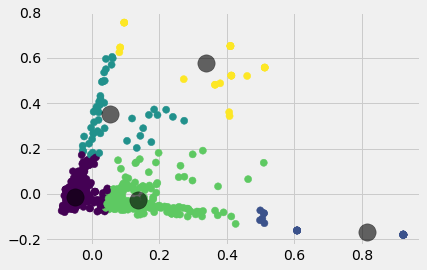

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);